<a href="https://colab.research.google.com/github/tomfox1/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Copy_of_LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [2]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=331.7442322602513, mobile=False), User(purchased=True, time_on_site=50.48795439875663, mobile=True), User(purchased=True, time_on_site=228.7750197571623, mobile=True), User(purchased=True, time_on_site=209.08340072307274, mobile=True), User(purchased=False, time_on_site=133.71519822805277, mobile=True), User(purchased=False, time_on_site=240.34572353008943, mobile=True), User(purchased=True, time_on_site=58.641454235092596, mobile=True), User(purchased=False, time_on_site=406.91493049197055, mobile=False), User(purchased=False, time_on_site=162.48609170639358, mobile=True), User(purchased=False, time_on_site=524.6906160625311, mobile=False)]


In [5]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,331.744232,False
1,True,50.487954,True
2,True,228.775020,True
3,True,209.083401,True
4,False,133.715198,True


In [6]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.683044650348858,5.755474626068274,6.21870114627869,6.401612512186324,6.496705818611178,6.6583984828461,7.071303874004219,7.794875529443148,8.014765633941796,8.021590757698053,...,569.2802226832731,572.3716817094405,582.8306126509216,588.2151968847126,590.9515496964939,592.5901229442519,596.3069497829132,598.0797553119105,599.2667385275163,599.3484283386554
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,0,0,...,0,1,1,1,1,1,0,1,0,1
True,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,1,0


In [7]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.089, 124.416]","(124.416, 243.149]","(243.149, 361.882]","(361.882, 480.615]","(480.615, 599.348]"
purchased,,,,,
False,227,207,117,31,23
True,115,138,98,16,28


In [8]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.089, 124.416]","(124.416, 243.149]","(243.149, 361.882]","(361.882, 480.615]","(480.615, 599.348]"
purchased,,,,,
False,0.663743,0.6,0.544186,0.659574,0.45098
True,0.336257,0.4,0.455814,0.340426,0.54902


In [9]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.632,0.596
True,0.368,0.404


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [11]:
#loading pandas and importing our CSV file from github 
import pandas as pd
people_data = pd.read_csv("https://raw.githubusercontent.com/tomfox1/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv")
people_data.head()

#dropping first column as it did not add any value
people_data_cleaned = people_data.drop(columns = ["Unnamed: 0"])
people_data_cleaned.head()


,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [12]:
import matplotlib.pyplot as plt
#y = exercise_time; x= age/weight 

#let's create 1 bin for each of the variables being analyzed, on Ryan's example earlier in class this was not needed since purchased = true/false
bins_age = pd.cut(people_data_cleaned["age"], 5)
bins_exercise = pd.cut(people_data_cleaned["exercise_time"], 5)

ct1 = pd.crosstab(bins_age, bins_exercise)
print(type(ct1))
ct1


<class 'pandas.core.frame.DataFrame'>


exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
age,,,,,
"(17.938, 30.4]",52,46,54,61,43
"(30.4, 42.8]",52,55,42,47,57
"(42.8, 55.2]",41,42,39,34,67
"(55.2, 67.6]",46,71,40,41,24
"(67.6, 80.0]",87,102,48,9,0


In [13]:
#converting data to % for better visualization
#A quick look on our data suggests long duration exercise drops and short duration exercise increases as people age. 
age_exercise = pd.crosstab(bins_age, bins_exercise, normalize = "columns")
print(type(age_exercise))
age_exercise

<class 'pandas.core.frame.DataFrame'>


exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
age,,,,,
"(17.938, 30.4]",0.187050,0.145570,0.242152,0.317708,0.225131
"(30.4, 42.8]",0.187050,0.174051,0.188341,0.244792,0.298429
"(42.8, 55.2]",0.147482,0.132911,0.174888,0.177083,0.350785
"(55.2, 67.6]",0.165468,0.224684,0.179372,0.213542,0.125654
"(67.6, 80.0]",0.312950,0.322785,0.215247,0.046875,0.000000


In [14]:
#quick look at the data tells us heavier people exercise for a shorter period of time. 
bins_weight = pd.cut(people_data_cleaned["weight"], 5)
ct2 = pd.crosstab(bins_weight, bins_exercise)
print(type(ct2))
ct2

<class 'pandas.core.frame.DataFrame'>


exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
weight,,,,,
"(99.854, 129.2]",53,65,71,79,107
"(129.2, 158.4]",44,76,67,74,74
"(158.4, 187.6]",61,93,56,38,10
"(187.6, 216.8]",76,73,29,1,0
"(216.8, 246.0]",44,9,0,0,0


In [15]:
#converting data to % for clarity
weight_exercise = pd.crosstab(bins_weight, bins_exercise, normalize = "columns")
print(type(weight_exercise))
weight_exercise

<class 'pandas.core.frame.DataFrame'>


exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
weight,,,,,
"(99.854, 129.2]",0.190647,0.205696,0.318386,0.411458,0.560209
"(129.2, 158.4]",0.158273,0.240506,0.300448,0.385417,0.387435
"(158.4, 187.6]",0.219424,0.294304,0.251121,0.197917,0.052356
"(187.6, 216.8]",0.273381,0.231013,0.130045,0.005208,0.000000
"(216.8, 246.0]",0.158273,0.028481,0.000000,0.000000,0.000000


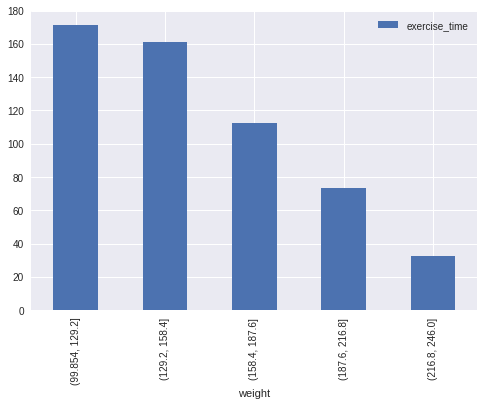

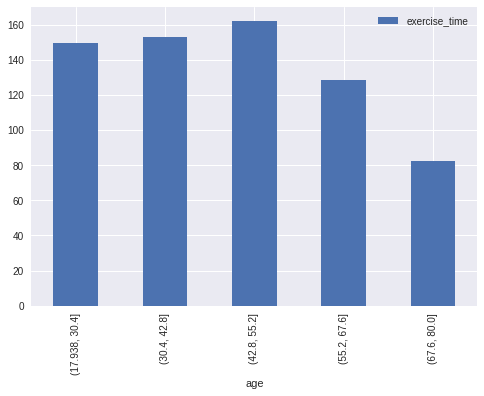

In [16]:
import pandas as pd
#exercise time is inversely proportional to weight. In regards to age, exercise time seems to increase and then decrease 
#help(people_data_cleaned.plot)
pd.pivot_table(people_data_cleaned, values = "exercise_time", index = bins_weight).plot.bar(), pd.pivot_table(people_data_cleaned, values = "exercise_time", index = bins_age).plot.bar();

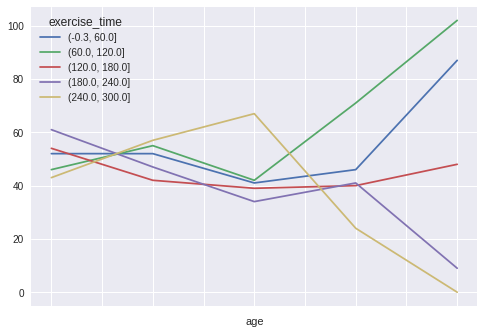

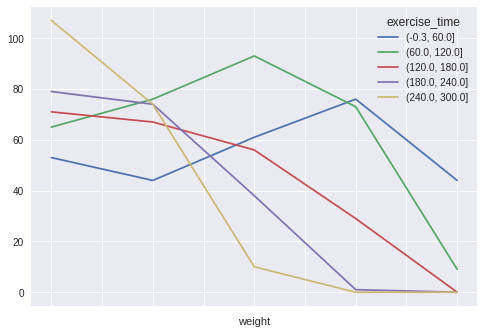

In [17]:
#the two graphs below are definitely more interesting then the ones above since we can visualize how each 1 of the 5 exercise time categories changes with time.
#it is visually clear that intense exercise subsides as people grow older, while light exercise increases as people grow older.
#in regards to weight, it is interesting to note that while exercise time decreases as a function of weight increase light exercise actually increases with weight before falling again as weight rises even further. 
ct1.plot(), ct2.plot();

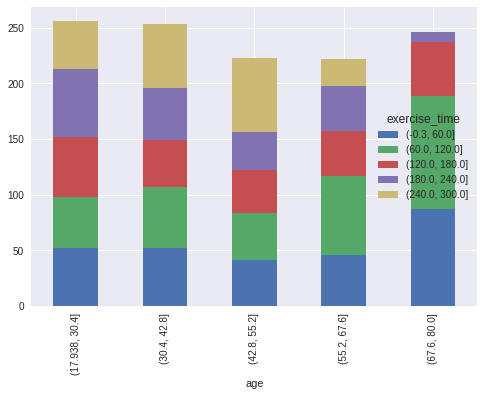

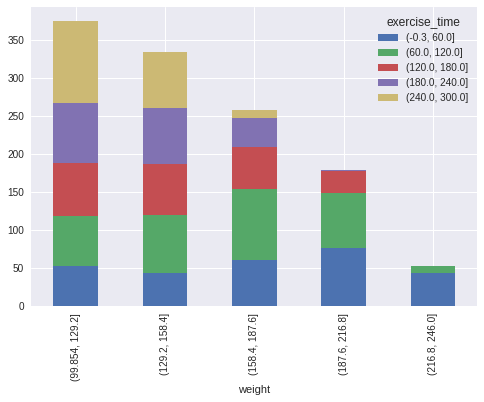

In [18]:
#the stacked bar charts tell us the same story however are less visually appealng and more confusing. 
#however, in regards to weight it is visually clear that as weight increases higher intensity exercise decreases as seen by the golden and purple colors. 
ct1.plot(kind = "bar", stacked = True), ct2.plot(kind = "bar", stacked = True);

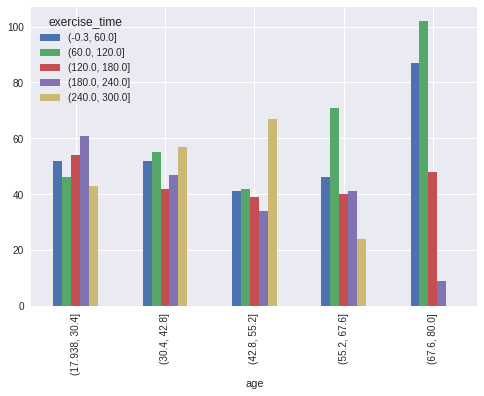

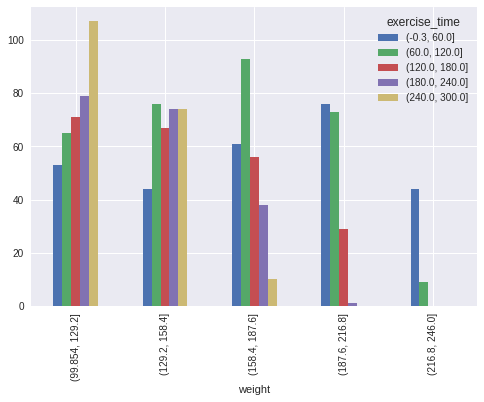

In [19]:
#These bar charts are definitely the worst of the graphs since they are "noisy" with information and don't convey a simple story. 
ct1.plot(kind = "bar"); ct2.plot(kind = "bar");

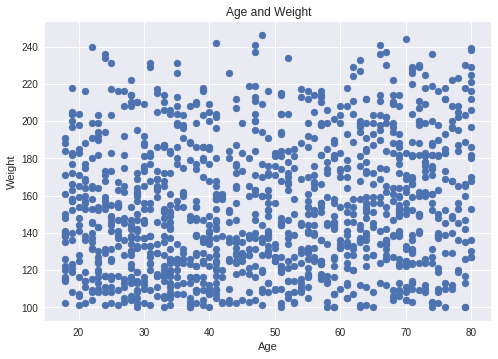

In [26]:
#To finalize, by plotting age and weight we can see how the two variables are not correlated. 
plt.scatter(people_data_cleaned["age"], people_data_cleaned["weight"]);
plt.title("Age and Weight")
plt.xlabel("Age")
plt.ylabel("Weight")
plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?




**ANSWERS:**

**1) In our data we have one dependent variable called "exercise time" and two dependent variables named "age" and "weight"**

**2) exercise time is dependent on both age and weight; as people age they exercise for a shorter amount of time and as they gain weight they also exercise for a shorter period of time (see comments throughout the notebook for greater detail)**

**3) We have a simple dataset with only three variables: exercise time, age, and weight. All three of those variables are real, however, age and weight are not correlated to one another and thus would provide us with spurious findings.**

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)